<a href="https://colab.research.google.com/github/likamonsavad/pakkie_duino/blob/main/TinyML-IntroToOptimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  %tensorflow_version 2.x
except Exception:
  pass


Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


Exception

In [7]:
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds


In [15]:
(raw_train, raw_validation, raw_test), metadata = tfds.load('cats_vs_dogs',
                                                            split = ['train[:80%]','train[80%:90%]','train[90%:]'],
                                                                     with_info = True, 
                                                                     as_supervised = True
                                                            )
#https://www.tensorflow.org/datasets/overview 
#https://www.tensorflow.org/datasets/overview#load_a_dataset

In [60]:
# Printing dataset information.
info = metadata
print("Number of  Classes: " + str(info.features['label'].num_classes))
print("Classes : " + str(info.features['label'].names))
NUM_TRAIN_IMAGES = tf.data.experimental.cardinality(raw_train).numpy()
print("Training Images: " + str(NUM_TRAIN_IMAGES))
NUM_VAL_IMAGES = tf.data.experimental.cardinality(raw_validation).numpy()
print("Validation Images: " + str(NUM_VAL_IMAGES))
NUM_TEST_IMAGES = tf.data.experimental.cardinality(raw_test).numpy()
print("Testing Images: " + str(NUM_TEST_IMAGES))

Number of  Classes: 2
Classes : ['cat', 'dog']
Training Images: 18610
Validation Images: 2326
Testing Images: 2326


,image,label
0,,1 (dog)
1,,1 (dog)
2,,1 (dog)

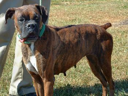
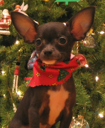
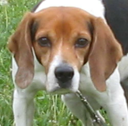

In [72]:
tfds.as_dataframe(raw_train.take(3), metadata)      


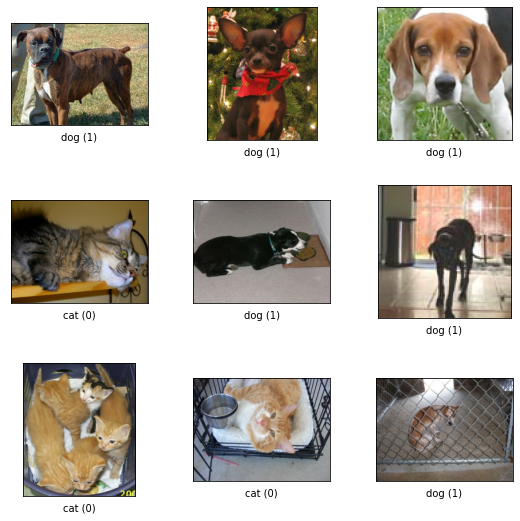

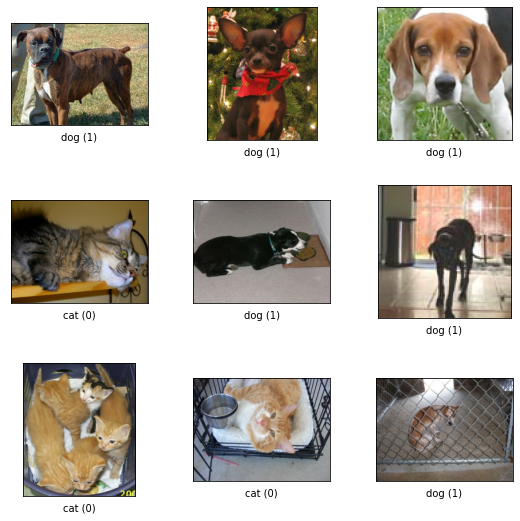

In [73]:
tfds.show_examples(raw_train, metadata)     

In [74]:
# display how much data we have
examples = metadata.splits['train'].num_examples
classes = metadata.features['label'].num_classes
print(examples)
print(classes)

23262
2


In [76]:
# format images to have normalized pixels
def format_image(image, label):
    image = tf.image.resize(image, (224, 224)) / 255.0
    return  image, label


'\nวิธี resize ด้านล่างนี้ก็ใช้ได้\n# Resizing images in the dataset.\ntrain_ds = train_ds.map(lambda x, y: (tf.image.resize(x, img_size), y))\nval_ds = val_ds.map(lambda x, y: (tf.image.resize(x, img_size), y))\ntest_ds = test_ds.map(lambda x, y: (tf.image.resize(x, img_size), y))\n'

In [80]:
# split the data in training, validation, and test datasets
BATCH_SIZE = 32
train_batches = raw_train.shuffle(examples // 4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = raw_validation.map(format_image).batch(BATCH_SIZE).prefetch(1)
test_batches = raw_test.map(format_image).batch(1)

In [81]:
#Let’s make sure to use buffered prefetching to yield data from the disk. 
#Prefetching overlaps the preprocessing and model execution of a training step. 
#Doing so reduces the step time to the training and the time it takes to extract the data.

In [82]:
# display the shape of our data
for image_batch, label_batch in train_batches.take(1):
    pass
image_batch.shape

TensorShape([32, 224, 224, 3])

In [83]:
'''
ใช้วิธีนี้แทน 76-78 ก็ได้ ด้านล่างนี้ก็ใช้ได้ 
# Defining batch size and input image size.
batch_size = 16
img_size = [224, 224]

# Resizing images in the dataset.
train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, img_size), y))
val_ds = val_ds.map(lambda x, y: (tf.image.resize(x, img_size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, img_size), y))

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
val_ds = val_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

'''

'\nใช้วิธีนี้แทน 76-78 ก็ได้ ด้านล่างนี้ก็ใช้ได้ \n# Defining batch size and input image size.\nbatch_size = 16\nimg_size = [224, 224]\n\n# Resizing images in the dataset.\ntrain_ds = train_ds.map(lambda x, y: (tf.image.resize(x, img_size), y))\nval_ds = val_ds.map(lambda x, y: (tf.image.resize(x, img_size), y))\ntest_ds = test_ds.map(lambda x, y: (tf.image.resize(x, img_size), y))\n\ntrain_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)\nval_ds = val_ds.cache().batch(batch_size).prefetch(buffer_size=10)\ntest_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)\n\n'

In [ ]:
module_selection = ("mobilenet_v2", 224, 1280) 
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE + (3,), 
                                   output_shape=[FV_SIZE],
                                   trainable=False)

print("Building model with", MODULE_HANDLE)

model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(classes, activation='softmax')
])

model.summary()


In [86]:
model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
EPOCHS = 5
hist = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches)

Epoch 1/5
582/582 [==============================] - 992s 2s/step - loss: 0.0506 - accuracy: 0.9836 - val_loss: 0.0417 - val_accuracy: 0.9854
Epoch 2/5
582/582 [==============================] - 826s 1s/step - loss: 0.0295 - accuracy: 0.9895 - val_loss: 0.0380 - val_accuracy: 0.9893
Epoch 3/5
582/582 [==============================] - 801s 1s/step - loss: 0.0241 - accuracy: 0.9917 - val_loss: 0.0447 - val_accuracy: 0.9871
Epoch 4/5
582/582 [==============================] - 799s 1s/step - loss: 0.0228 - accuracy: 0.9924 - val_loss: 0.0398 - val_accuracy: 0.9888
Epoch 5/5
582/582 [==============================] - 797s 1s/step - loss: 0.0183 - accuracy: 0.9941 - val_loss: 0.0400 - val_accuracy: 0.9884



# Saved Model

In [87]:
CATS_VS_DOGS_SAVED_MODEL = "exp_saved_model"
tf.saved_model.save(model, CATS_VS_DOGS_SAVED_MODEL)

# Your task starts here:

*   Run this code, and you'll have model1.tflite, with no optimization or quantization
*   Then, remove the comment on the `converter.optimizations = []` line. Change the model name to model2.tflite, and rerun. Model2.tflite will now have optimizations added -- you should see a much smaller file size.
*   Finally, remove the comments on the code to add a representative dataset and set the supported ops as shown. Change the model name to model3.tflite, and rerun. Model3.tflite will now have optimizations added, along with quantization from the representative dataset. Note: it might be slightly larger than model2.tflite!

**Note**: `tf.lite.Optimize` has changed and the `OPTIMIZE_FOR_SIZE` and `OPTIMIZE_FOR_LATENCY` options are now deprecated and are the same and DEFAULT: https://www.tensorflow.org/api_docs/python/tf/lite/Optimize

In [100]:
import pathlib
converter = tf.lite.TFLiteConverter.from_saved_model(CATS_VS_DOGS_SAVED_MODEL)

# These options are for converter optimizaitons
# Consider trying the converter without them and
# explore model size and accuracy
# Then...use them and reconvert the model and explore model
# size an accuracy at that point. What differences do you see?

converter.optimizations = [tf.lite.Optimize.DEFAULT]    # Uncomment this line for Model 2 and Model 3

def representative_data_gen():                          # Uncomment the following 5 lines for Model 3
     for input_value, _ in test_batches.take(100):
         yield [input_value]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

tflite_model = converter.convert()
tflite_models_dir = pathlib.Path("/tmp/")

tflite_model_file = tflite_models_dir/'model2.tflite'     # Change the filename here for Model2 and Model3!
tflite_model_file.write_bytes(tflite_model) #print out how many memory in bytes the model has taken.


# Without any optimizations I got
# 8857848  (model1.tflite)
# With the .optimizations property set I got
# 2629648 (model2.tflite)
# With the .optimizations property and representative data set I got
# 2835952 -- Slightly larger!  (model3.tflite)

2713024

### Your task continues
Now we will test the accuracy of the three models! After you run each model you will get the number of correct predictions and then you can plot which images were correct/incorrect!
+ Run this code
+ Change the model file to model2.tflite and run it again
+ Change the model file to model3.tflite and run it again

In [101]:
#@title Run this cell each time to test your model's accuracy (make sure to change the filename)
from tqdm import tqdm
# Load TFLite model and allocate tensors.
tflite_model_file = '/tmp/model2.tflite'                 # Change the filename here for Model 2 and 3
interpreter = tf.lite.Interpreter(model_path=tflite_model_file)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

predictions = []

test_labels, test_imgs = [], []
for img, label in tqdm(test_batches.take(100)):
    interpreter.set_tensor(input_index, img)
    interpreter.invoke()
    predictions.append(interpreter.get_tensor(output_index))
    
    test_labels.append(label.numpy()[0])
    test_imgs.append(img)

# For model 1, I got 32.25 it/s
# For model 2, I got 16.16 it/s
# For model 3, I got 1.19s it/s
# Note: since the it/s will depend on the computer on which your Colab VM
#       instance is running -- we would expect it to vary a bit.
# Note2: Changes have been made to the TFLite Interpreter since Laurence filmed the
#        previous video that further optimize it for mobile use at the expense of
#        speed in Colab. As such, you'll find that while Laurence was able to achieve
#        16 it/s for model 2, you may only see speeds of 1-2 it/s

score = 0
for item in range(0,100):
  prediction=np.argmax(predictions[item])
  label = test_labels[item]
  if prediction==label:
    score=score+1

print("Out of 100 predictions I got " + str(score) + " correct")

# Model 1 - 100 Correct
# Model 2 - 99 Correct
# Model 3 - 99 Correct
# Note: since training starts from a random intialization it would not be 
#       surprising if your result is off by 1 or 2 correct.

100%|██████████| 100/100 [00:02<00:00, 38.25it/s]

Out of 100 predictions I got 100 correct


In [102]:
#@title Define utility functions once for plotting
# Utilities for plotting

class_names = ['cat', 'dog']

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    img = np.squeeze(img)

    plt.imshow(img, cmap=plt.cm.binary)
    
    predicted_label = np.argmax(predictions_array)
    
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'
    
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100*np.max(predictions_array),
                                         class_names[true_label]), color=color)

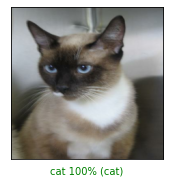

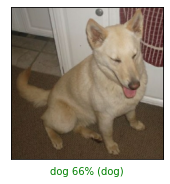

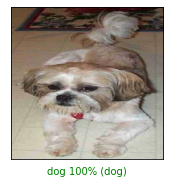

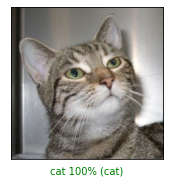

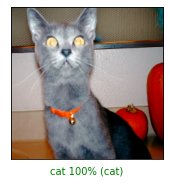

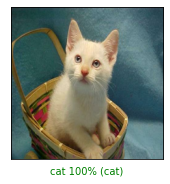

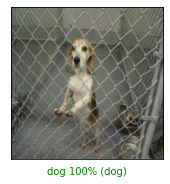

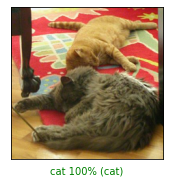

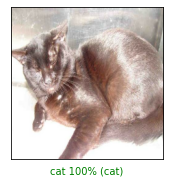

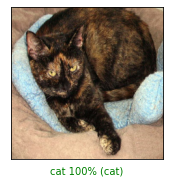

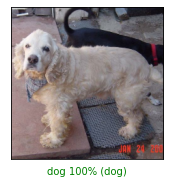

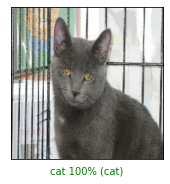

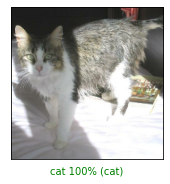

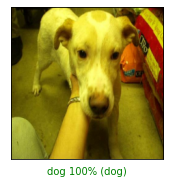

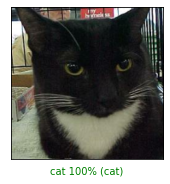

In [106]:
#@title Visualize the outputs each time { run: "auto" }
max_index = 15 #@param {type:"slider", min:1, max:100, step:1}
for index in range(0,max_index):
  plt.figure(figsize=(6,3))
  plt.subplot(1,2,1)
  plot_image(index, predictions, test_labels, test_imgs)
  plt.show()